# Chapter 6: The Coalescent - Complementary msprime demo

## Simulating the coalescent

### Coalescent genealogies

Corresponding subchapter outlines the methodology for generating simple coalescent genealogies. We will replicate examples from this chapter using coalescent simulator msprime.

"msprime is an reimplementation of Hudson's ms program for simulating genomic datasets under the coalescent model with recombination. msprime is capable of simulating sample sizes far larger than any other simulators, and is generally extremely efficient. Because it simulates datasets with the tree sequence structure, extracting statistics from the simulations is generally also extremely quick. We will see that it can easily simulate chromosome-sized regions for hundreds of thousands of samples, allowing us to explore the influence of various historical scenarios on observed patterns of genetic variation and inheritance on a scale that was previously impossible."

Starting from loading required python libraries:

In [103]:
import msprime
import numpy as np
import scipy
from IPython.display import SVG
import tskit
#import allel
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import io

import matplotlib as ml
%matplotlib inline
font = {'family' : 'Sans', 'weight' : 'normal','size': 16}
ml.rc('font', **font)
ml.rcParams['figure.figsize'] = (5.0, 5.0)
ml.rcParams['text.usetex'] =False
ml.rc('font', family='serif',size=16)

We will first simulate genealogy of 5 chromosomes (samples in msprime terminology) to replicate Figure 6.2.
We only need to specify one parameter - n

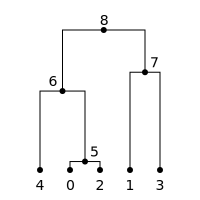

In [9]:
ts = msprime.simulate(sample_size = 5, random_seed = 1)
tree = ts.first()
SVG(tree.draw())

msprime stores genealogy information in a table format called TreeSequence, further we will take a closer look at it's structure.

We can now run the simulation above multiple times to ensure, that each simulation will produce different genealogy (Figure 6.3) 

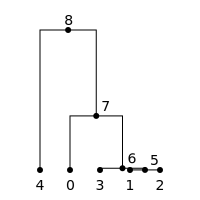

In [13]:
ts = msprime.simulate(sample_size = 5)
tree = ts.first()
SVG(tree.draw())

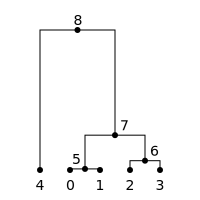

In [14]:
ts = msprime.simulate(sample_size = 5)
tree = ts.first()
SVG(tree.draw())

To simulate genetic variation, we'll need to add some mutations to our tree sequences. Mutations are generated in msprime by sprinkling mutations over the branches of trees at a rate specified by the mutation_rate input to simulate. msprime supports simulating mutations under the infinitely many sites model. 

Note: we provide the scaled mutation rate θ

We will now replicate Figure 6.4 by introducing new parameter: mutation_rate

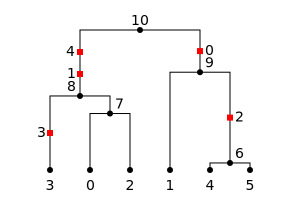

In [34]:
ts = msprime.simulate(sample_size = 6, random_seed = 2, mutation_rate = 1)

for tree in ts.trees():
    #print('Tree on interval', tree.interval)
    display(SVG(tree.draw(width=300)))    

In [33]:
print('Site ID\t', 'Site position\t\t', 'Alleles\t', 'Genotypes\t')
for var in ts.variants():
    print(var.site.id, var.site.position, var.alleles, var.genotypes, sep="\t")

Site ID	 Site position		 Alleles	 Genotypes	
0	0.07964547094888985	('0', '1')	[0 1 0 0 1 1]
1	0.4942368404008448	('0', '1')	[1 0 1 1 0 0]
2	0.5867969789542258	('0', '1')	[0 0 0 0 1 1]
3	0.8182267220690846	('0', '1')	[0 0 0 1 0 0]
4	0.8539752908982337	('0', '1')	[1 0 1 1 0 0]


## Understanding the coalescent

Here we will replicate some of the theoretical predictions from the coalescent theory. Simulations modified from Kelleher & Lohse tutorial. 

### Total tree length

Expected total tree length mathematically described in equation 6.4. 
We can check, if our simulations meet theoretical expectation. In order to do that, we need to repeat our simulation multiple times (parameter num_replicates). Additionally, we can test how length of the genealogy depends on number individuals involved (variable ns).

(Besides msprime, numpy, pandas and seaborn libraries are used here. Feel free to ignore it, if it's not helpful:)

In [43]:
#simulating data
ns = np.array([5, 10, 20, 30]) #setting different sample sizes
num_reps = 10000 #number of replicates
n_col = np.zeros(ns.shape[0] * num_reps)
T_total_col = np.zeros(ns.shape[0] * num_reps)
row = 0
for n in ns:
    for ts in msprime.simulate(n, Ne=0.5, num_replicates=num_reps):
        tree = ts.first()
        n_col[row] = n
        T_total_col[row] = tree.total_branch_length
        row += 1
df = pd.DataFrame({"n": n_col, "T_total": T_total_col})

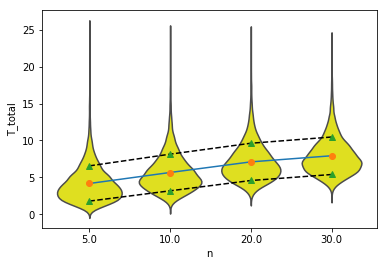

In [40]:
def T_total_mean(n):
    return 2 * np.sum(1 / np.arange(1, n))

def T_total_var(n):
    return 4 * np.sum(1 / np.arange(1, n)**2)

mean_T = np.array([T_total_mean(n) for n in ns])
stddev_T = np.sqrt(np.array([T_total_var(n) for n in ns]))
ax = sns.violinplot(x="n", y="T_total", data=df, color="yellow", inner=None)
ax.plot(mean_T, "-");
ax.plot(mean_T - stddev_T, "--", color="black");
ax.plot(mean_T + stddev_T, "--", color="black");
group = df.groupby("n")
mean_sim = group.mean()
stddev_sim = np.sqrt(group.var())
x = np.arange(ns.shape[0])
ax.plot(x, mean_sim, "o")
line, = ax.plot(x, mean_sim - stddev_sim, "^")
ax.plot(x, mean_sim + stddev_sim, "^", color=line.get_color());
plt.show()

Let's try to simulate data Leptidea sample set used for recombination experiment by providing equivalent sample size.

In [50]:
ns = np.array([89]) #setting different sample sizes
num_reps = 10000 #number of replicates
n_col = np.zeros(ns.shape[0] * num_reps)
T_total_col = np.zeros(ns.shape[0] * num_reps)
row = 0
for n in ns:
    for ts in msprime.simulate(n, Ne=0.5, num_replicates=num_reps):
        tree = ts.first()
        n_col[row] = n
        T_total_col[row] = tree.total_branch_length
        row += 1
df = pd.DataFrame({"n": n_col, "T_total": T_total_col})

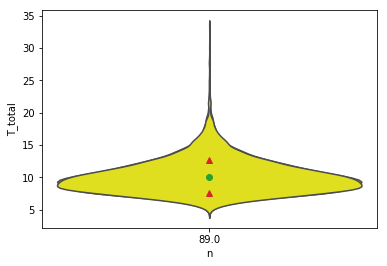

In [52]:
mean_T = np.array([T_total_mean(n) for n in ns])
stddev_T = np.sqrt(np.array([T_total_var(n) for n in ns]))
ax = sns.violinplot(x="n", y="T_total", data=df, color="yellow", inner=None)
ax.plot(mean_T, "-");
ax.plot(mean_T - stddev_T, "--", color="black");
ax.plot(mean_T + stddev_T, "--", color="black");
group = df.groupby("n")
mean_sim = group.mean()
stddev_sim = np.sqrt(group.var())
x = np.arange(ns.shape[0])
ax.plot(x, mean_sim, "o")
line, = ax.plot(x, mean_sim - stddev_sim, "^")
ax.plot(x, mean_sim + stddev_sim, "^", color=line.get_color());
plt.show()

In [ ]:
More theory?



### Coalescent with recombination

The key idea
Common haplotypes in a sample are often simply a consequence of some common history. So if we know this history (as we always do in simulations!), storing it directly is often more convenient and efficient than storing the raw haplotypes.
A tree sequence is an encoding of a complete genealogy for a sample of chromosomes at each chromosomal location [1]. They offer a few benefits to population geneticists compared with traditional genetic file formats:
They can store large simulated datasets extremely compactly. (Often >100 of times smaller than VCFs for real-sized datasets!)
As they hold rich detail about the history of the sample, many important processes can be observed directly from the tree structure. So a tree sequence is often more informative than raw genotype/haplotype data, even though it is also more compact.
They can be queried and modified extremely quickly. In later workshops we will see that this enables quick calculation of many important population statistics.

https://github.com/DRL/SMBE-SGE-2019/blob/master/Session_1/pics/tree-sequence.png

In [79]:
ts.num_nodes
ts.num_edges

8

In [96]:
tables = ts.tables
print(tables)

############################################################
#   Individuals                                            #
############################################################
id	flags	location	metadata
############################################################
#   Nodes                                                  #
############################################################
id	flags	population	individual	time	metadata
0	1	0	-1	0.00000000000000	
1	1	0	-1	0.00000000000000	
2	1	0	-1	0.00000000000000	
3	1	1	-1	0.00000000000000	
4	1	2	-1	0.00000000000000	
5	0	2	-1	0.52162613928359	
6	0	2	-1	2.57049316969641	
7	0	0	-1	2.95627062612079	
8	0	0	-1	12.27320490288726	
############################################################
#   Edges                                                  #
############################################################
id	left		right		parent	child
0	0.00000000	1.00000000	5	0
1	0.00000000	1.00000000	5	4
2	0.00000000	1.00000000	6	3
3	0.00000000	1.0000000

We can simulate entire chromosome-sized sequences with msprime. To do this, we will often want to add in a model of recombination.

To simulate with a constant recombination rate, we specify two extra inputs to simulate: a sequence length (most easily specified as a number of bases) and a recombination_rate (specified as the rate of crossovers per unit of length per generation).

Tree on interval: (0.0, 0.5)


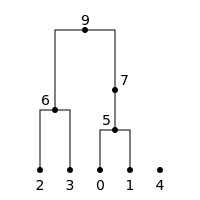


Tree on interval: (0.5, 1.0)


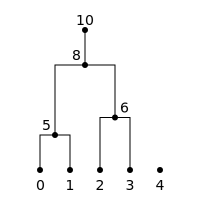

In [94]:
# Modify this code.
nodes_ex = io.StringIO("""\
id      is_sample   population      time
0       1       0               0.0
1       1       0               0.0
2       1       0               0.0
3       1       0               0.0
4       1       0               0.0
5       0       0               1.0
6       0       0               1.5
7       0       0               2.0
8       0       0               3.0
9       0       0               3.5
10      0       0               4.0
""")
edges_ex = io.StringIO("""\
id      left            right           parent  child
0       0.00000000      1.00000000      5       0
1       0.00000000      1.00000000      5       1
2       0.00000000      1.00000000      6       2
3       0.00000000      1.00000000      6       3
4       0.00000000      0.50000000      7       5
5       0.50000000      1.00000000      8       5
6       0.50000000      1.00000000      8       6
7       0.00000000      0.50000000      9       6
8       0.00000000      0.50000000      9       7
9       0.50000000      1.00000000      10      8
""")

# Load the tree sequence.
ts_ex = tskit.load_text(nodes=nodes_ex, edges=edges_ex, strict=False)

# Test by plotting it.
for tree in ts_ex.trees():
    print('Tree on interval:', tree.interval)
    display(SVG(tree.draw()))
    print()

In [97]:
print(tables.mutations)

id	site	node	derived_state	parent	metadata


Tree on interval (0.0, 181.74732201307717)


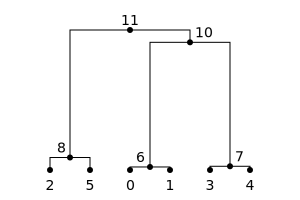

Tree on interval (181.74732201307717, 1000.0)


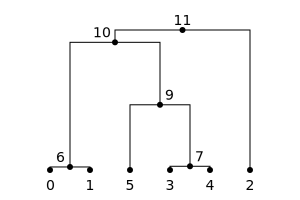

In [54]:
ts = msprime.simulate(sample_size = 6, random_seed = 12, length = 1000, 
                      recombination_rate = 1e-4 )

for tree in ts.trees():
    print('Tree on interval', tree.interval)
    display(SVG(tree.draw(width=300)))

It's also possible to simulate under a variable rate of recombination. To do this, we can specify an external recombination map given as a RecombinationMap object. See the msprime documentation for more information about these objects.

In [69]:
ts = msprime.simulate(10, Ne=1e4, length=1e5, recombination_rate=1e-8, random_seed=3)
ts.num_trees

82

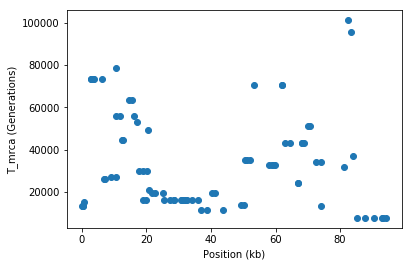

In [73]:
tmrca = np.zeros(ts.num_trees)
breakpoints = np.zeros(ts.num_trees)
for tree in ts.trees():
    tmrca[tree.index] = tree.time(tree.root)  
    breakpoints[tree.index] = tree.interval[0]
plt.ylabel("T_mrca (Generations)")
plt.xlabel("Position (kb)")
plt.plot(breakpoints / 1000, tmrca, "o");
plt.show()

Positions on the map  [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
Recombination rates  [0, 0.0001, 0.0005, 0.0001, 0, 0, 0, 0.0005, 0.0006, 0.0001, 0]
Tree on interval (0.0, 249.06398236496932)


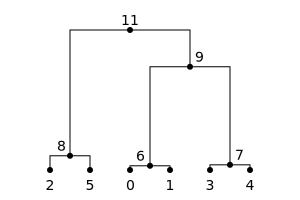

Tree on interval (249.06398236496932, 849.2285334503345)


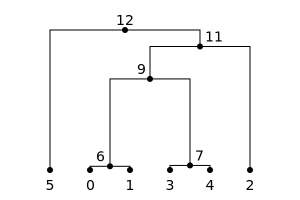

Tree on interval (849.2285334503345, 1000.0)


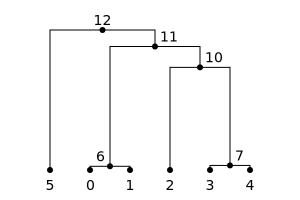

In [60]:
# Making a simple RecombinationMap object.
map_positions = [i*100 for i in range(0, 11)]
map_rates = [0, 1e-4, 5e-4, 1e-4, 0, 0, 0, 5e-4, 6e-4, 1e-4, 0]
my_map = msprime.RecombinationMap(map_positions, map_rates)
print("Positions on the map ",map_positions)
print("Recombination rates ", map_rates)

# Simulating with the recombination map.
ts = msprime.simulate(sample_size = 6, random_seed = 12, recombination_map = my_map)

for tree in ts.trees():
    print('Tree on interval', tree.interval)
    display(SVG(tree.draw(width=300)))

In [62]:
# Read in the recombination map and run the simulation.
infile = "genetic_map_GRCh37_chr22.txt"
recomb_map = msprime.RecombinationMap.read_hapmap(infile)
ts = msprime.simulate(
    sample_size=100,
    Ne=10**4,
    recombination_map=recomb_map,
    random_seed=1)

FileNotFoundError: [Errno 2] No such file or directory: 'genetic_map_GRCh37_chr22.txt'

In [64]:
recomb_map = msprime.RecombinationMap.uniform_map(length=10, rate=1, num_loci=10)
ts = msprime.simulate(2, recombination_map=recomb_map)
list(ts.breakpoints())

[0.0, 9.0, 10.0]

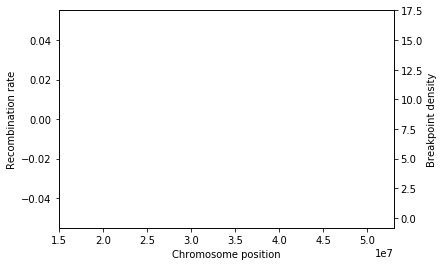

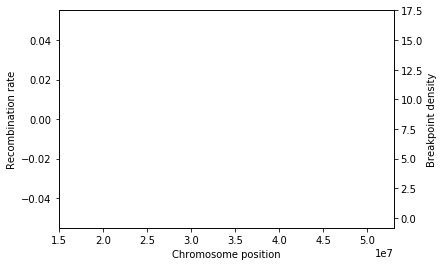

In [68]:
# Now plot the density of breakpoints along the chromosome
breakpoints = np.array(list(ts.breakpoints()))
# Now we get the positions and rates from the recombination
# map and plot these using 500 bins.
positions = np.array(recomb_map.get_positions()[1:])
rates = np.array(recomb_map.get_rates()[1:])
num_bins = 500
v, bin_edges, _ = scipy.stats.binned_statistic(
    positions, rates, bins=num_bins)
x = bin_edges[:-1][np.logical_not(np.isnan(v))]
y = v[np.logical_not(np.isnan(v))]
fig, ax1 = plt.subplots()
ax1.plot(x, y, color="blue")
ax1.set_ylabel("Recombination rate")
ax1.set_xlabel("Chromosome position")
ax2 = ax1.twinx()
v, bin_edges = np.histogram(breakpoints, num_bins, density=True)
ax2.plot(bin_edges[:-1], v, color="green")
ax2.set_ylabel("Breakpoint density")
ax2.set_xlim(1.5e7, 5.3e7);
plt.show()

# Demographic modelling in msprime

In [74]:
def pairwise_T_mrca(Ne):
    N = 10000
    T_mrca = np.zeros(N)
    for j, ts in enumerate(msprime.simulate(2, Ne=Ne, num_replicates=N)):
        tree = ts.first()
        T_mrca[j] = tree.time(tree.root)
    return np.mean(T_mrca)

pairwise_T_mrca(0.5), pairwise_T_mrca(10), pairwise_T_mrca(100)

(0.9761364809325923, 19.892860126271565, 204.09184716199712)

In [75]:
def pairwise_T_mrca(growth_rate):
    N = 10000
    T_mrca = np.zeros(N)    
    replicates = msprime.simulate(
        population_configurations=[
             msprime.PopulationConfiguration(
                sample_size=2, initial_size=0.5, growth_rate=growth_rate)], 
        num_replicates=N, random_seed=100)
    for j, ts in enumerate(replicates):
        tree = ts.first()
        T_mrca[j] = tree.time(tree.root)
    return np.mean(T_mrca)

pairwise_T_mrca(0.05), pairwise_T_mrca(0), pairwise_T_mrca(-0.05)

(0.9342695408215712, 0.977927540084271, 1.0311575984750108)

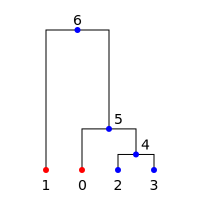

In [76]:
pop_configs = [
    msprime.PopulationConfiguration(sample_size=2),
    msprime.PopulationConfiguration(sample_size=2)
]
M = np.array([
    [0, 0.1],
    [0, 0]
])
ts  = msprime.simulate(
    population_configurations=pop_configs, migration_matrix=M,
    random_seed=2)
tree = ts.first()
colour_map = {0:"red", 1:"blue"}
node_colours = {u: colour_map[tree.population(u)] for u in tree.nodes()}
SVG(tree.draw(node_colours=node_colours))

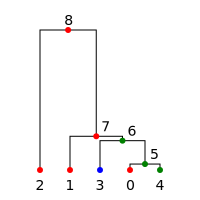

In [77]:
pop_configs = [
    msprime.PopulationConfiguration(sample_size=3),
    msprime.PopulationConfiguration(sample_size=1),
    msprime.PopulationConfiguration(sample_size=1)]
M = [
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0]]
ts  = msprime.simulate(
    population_configurations=pop_configs, migration_matrix=M, record_migrations=True,
    random_seed=101)
tree = ts.first()
colour_map = {0:"red", 1:"blue", 2: "green"}
node_colours = {u: colour_map[tree.population(u)] for u in tree.nodes()}
SVG(tree.draw(node_colours=node_colours))

In [98]:
%%time
num_populations = 5 # Number of populations
n = 20000  # Per population sample size.
population_configs = [
    msprime.PopulationConfiguration(sample_size=n) 
    for _ in range(num_populations)
]
ts = msprime.simulate(
    Ne=10**4, mutation_rate=1e-8, recombination_rate=1e-8,
    length=1e7,  # 10 Mb
    population_configurations=[
        msprime.PopulationConfiguration(sample_size=n) 
        for _ in range(num_populations)
    ],
    migration_matrix=np.zeros((num_populations, num_populations)),
    demographic_events=[
        msprime.MassMigration(5000, source=1, dest=0, proportion=1),
        msprime.MassMigration(10000, source=2, dest=0, proportion=1),
        msprime.MassMigration(15000, source=3, dest=0, proportion=1),
        msprime.MassMigration(20000, source=4, dest=0, proportion=1),
    ]
)
print("num trees = ", ts.num_trees, "num sites = ", ts.num_sites)

num trees =  184920 num sites =  191042
CPU times: user 18.2 s, sys: 207 ms, total: 18.4 s
Wall time: 18.4 s


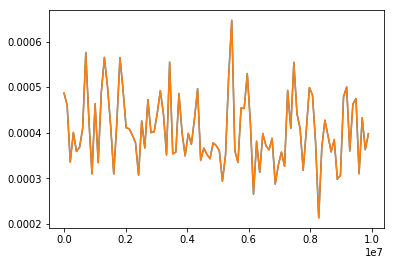

CPU times: user 488 ms, sys: 57.7 ms, total: 546 ms
Wall time: 356 ms


In [100]:
%%time
num_windows = 100
windows=np.linspace(0, ts.sequence_length, num=num_windows)

pop0_div = ts.diversity([ts.samples(0)], windows=windows)
plt.plot(windows[:-1], pop0_div)
plt.show()

CPU times: user 399 ms, sys: 64.5 ms, total: 463 ms
Wall time: 462 ms


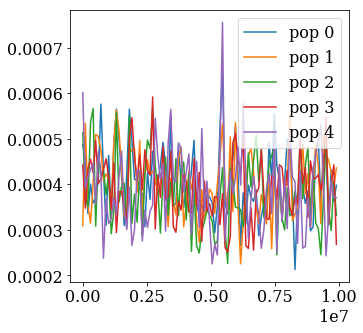

In [106]:
%%time
pop_samples = [ts.samples(j) for j in range(ts.num_populations)]
div = ts.diversity(pop_samples, windows=windows)
lines = plt.plot(windows[:-1], div)
plt.legend(lines, [f"pop {j}" for j in range(ts.num_populations)]);